# **Used Car Price Prediction**

## Problem Definition

We begin by stating the problem the below aims to solve. 

We are building models to determine whether the sales price of a specific used car will be more than $10,000. 

The dataset is a sampling set of data that includes details on used vehicles sold by various auto dealers.

## Exploratory Data Analysis

**We continue by importing the necessary libraries.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

**Reading in the data set and getting an overview**

In [2]:
data = pd.read_csv('cars.csv')

**Displaying the top rows of data**

In [3]:
data.head()

,id,odometer,year,engine_type,engine_capacity,body_type,high_10
0,C1005447,270000.0,2000,diesel,2.4,universal,0
1,C1005777,190000.0,2011,diesel,2.0,sedan,1
2,C1004693,280000.0,1997,gasoline,1.8,universal,0
3,C1007805,339000.0,2010,diesel,2.0,universal,1
4,C1011861,244000.0,2000,gasoline,2.4,sedan,0


**Getting basic statistic details about the data**

In [4]:
data.describe()

,odometer,year,engine_capacity,high_10
count,19999.000000,20000.000000,19991.000000,20000.000000
mean,247892.514776,2002.991250,2.054883,0.227650
std,136089.279290,8.055521,0.674824,0.419326
min,-52.000000,1942.000000,0.000000,0.000000
25%,156000.000000,1998.000000,1.600000,0.000000
50%,248532.000000,2003.000000,2.000000,0.000000
75%,325000.000000,2009.000000,2.300000,0.000000
max,1000000.000000,2040.000000,7.500000,1.000000


**Provide information about columns, data type, and missing values**

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               20000 non-null  object 
 1   odometer         19999 non-null  float64
 2   year             20000 non-null  int64  
 3   engine_type      20000 non-null  object 
 4   engine_capacity  19991 non-null  float64
 5   body_type        20000 non-null  object 
 6   high_10          20000 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 1.1+ MB


In [6]:
data.isnull().sum()

id                 0
odometer           1
year               0
engine_type        0
engine_capacity    9
body_type          0
high_10            0
dtype: int64

It can be seen that there are null values in odometer and engine_capacity. We think these two columns play an important role in determining car prices, so we need to fill the null values. To do that, we need to understand the data distribution of these two columns.

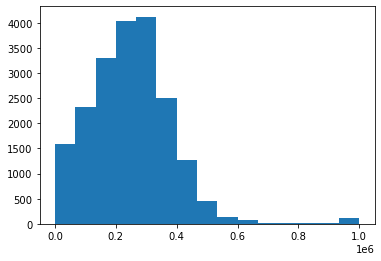

In [7]:
# Data distribution of odometer
plt.hist(data['odometer'],bins=15)
plt.show()

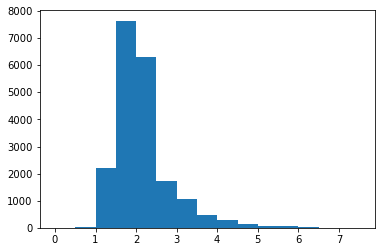

In [8]:
# Data distribution of engine capacity
plt.hist(data['engine_capacity'],bins=15)
plt.show()

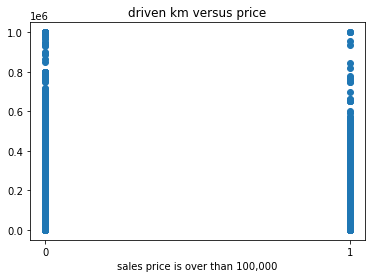

In [9]:
plt.scatter(data['high_10'],data['odometer'])
plt.xticks([0,1])
plt.title('driven km versus price')
plt.xlabel('sales price is over than 100,000')
plt.show()

**Additional exploring of the data distributions of values with prices above or below $100,000**

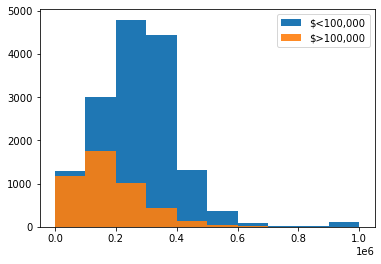

In [10]:
df_0 = data[data['high_10'] == 0]
df_1 = data[data['high_10'] == 1]
plt.hist(df_0['odometer'],label='$<100,000')
plt.hist(df_1['odometer'],label='$>100,000',alpha=0.9)
plt.legend()
plt.show()

### Data Preparation


Since the distributions of odometer and engine capacity are both skewed, it will be ideal to fill null values with their respective median data.

In [11]:
data['odometer'].fillna(data['odometer'].median(),inplace =True)
data['engine_capacity'].fillna(data['engine_capacity'].median(),inplace =True)

Now that we have the full dataset ready, we can visualize the relationship between pairwise variables with regard to the response variable(high_10).

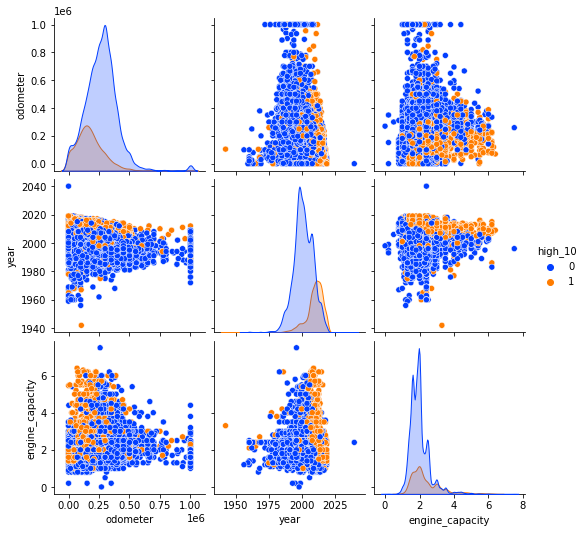

In [12]:
sns.pairplot(data, hue="high_10", palette='bright')

**Odometer**: 1's for high_10 are clustered at the lower bound of odometer, indicating that car prices are more likely to exceed 10,000.

**Year**: 1's are more clustered at the higher end of the year, which also makes sense in real-life setting. Cars with latest manufacture year are usually more expensive.

**Engine Capacity**: It seems that engine capacity alone has very little influence on car prices. However, it might have bigger impact once it it combined with other factor such as body type.

We think engine type and body type are likely to be crucial elements in determining the price. However, these two columns only contain categorical data, so we need to convert them into numerical data because machine learning algorithms can only work with numerical data as inputs. Here, we are going to use one hot encoding.

First we need to review the unique values to find classes for the two variables.

In [13]:
data['engine_type'].unique()

array(['diesel', 'gasoline', 'electric'], dtype=object)

In [14]:
data['body_type'].unique()

array(['universal', 'sedan', 'hatchback', 'minivan', 'suv', 'coupe',
       'liftback', 'van', 'minibus', 'cabriolet', 'pickup', 'limousine'],
      dtype=object)

In [19]:
# Create one hot encoding columns and rename the columns
engine_onehot = pd.get_dummies(data['engine_type'])
engine_onehot.columns = ['engine_diesel','engine_gasoline','engine_electric']
body_onehot = pd.get_dummies(data['body_type'])
body_onehot.columns = ['body_universal','body_sedan','body_hatchback','body_minivan','body_suv',
                      'body_coupe','body_liftback','body_van','body_minibus','body_cabriolet',
                      'body_pickup','body_limousine']

In [18]:
# Concatenate the two dataframe with the original dataset
data = pd.concat([data,engine_onehot,body_onehot],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               20000 non-null  object 
 1   odometer         20000 non-null  float64
 2   year             20000 non-null  int64  
 3   engine_type      20000 non-null  object 
 4   engine_capacity  20000 non-null  float64
 5   body_type        20000 non-null  object 
 6   high_10          20000 non-null  int64  
 7   engine_diesel    20000 non-null  uint8  
 8   engine_gasoline  20000 non-null  uint8  
 9   engine_electric  20000 non-null  uint8  
 10  body_universal   20000 non-null  uint8  
 11  body_sedan       20000 non-null  uint8  
 12  body_hatchback   20000 non-null  uint8  
 13  body_minivan     20000 non-null  uint8  
 14  body_suv         20000 non-null  uint8  
 15  body_coupe       20000 non-null  uint8  
 16  body_liftback    20000 non-null  uint8  
 17  body_van    

**Now we assign predictor variables to variable X. X is capitalized to indicate there are multiple predictor variables.
We also assign response variable "high_10" to variable y**

In [54]:
X = X = data.iloc[:,[1,2,4,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]].values
y = data.iloc[:,6].values

In [55]:
# evaluate the proportion of '1' among all dataset
data['high_10'].sum()/len(data['high_10'])

0.22765

## Modeling

**Splitting data into training sets and test sets**

We can divide our data set into two parts: one half will be used for training and the other half will be utilised to test the data set in order to avoid problems like overfitting. It also provides us some data to test and evaluate the learning algorithms on. 

We add stratify = y to make sure the random split has 23% of 1's and 77% 0's in both the training and test dataset.

In [56]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
print ('X train shape:',X_train.shape,'\n','X test shape:',X_test.shape)

X train shape: (16000, 18) 
 X test shape: (4000, 18)


### K-nearest Neighbors Model




K-nearest Neighbors is a typical way to deal with classification. As this algorithm relies on the Euclidean distance between the data points, it is a must to bring all the features to the same scale for applying distance based algorithms like KNN. Otherwise, variables with bigger distance will have higher weights in impacting the model, which can be confusing.

In [57]:
# define the scaler and then we fit it into X_train
scaler = StandardScaler()
scaler.fit(X_train)

# After the average and standard deviation of X_train is retrieved, we use transform method to scale both X_train and X_test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[-0.63046431,  0.25241253, -0.67340414, ..., -0.39716798,
        -0.41388776, -0.14444344],
       [-0.5719876 ,  0.87429059, -0.3770751 , ...,  2.51782635,
        -0.41388776, -0.14444344],
       [-0.16996021, -0.12071431, -0.82156867, ..., -0.39716798,
        -0.41388776, -0.14444344],
       ...,
       [-0.08955474, -1.48884604,  0.80824108, ..., -0.39716798,
        -0.41388776, -0.14444344],
       [ 0.28323429,  0.50116376, -0.3770751 , ..., -0.39716798,
        -0.41388776, -0.14444344],
       [ 1.84017669, -0.12071431, -0.08074605, ..., -0.39716798,
        -0.41388776, -0.14444344]])

The value for K is crucial. A k value that is too small can result in overfitting,which fails to generalize the model, while a large k value might cause underfitting. We will create a "for" loop to track the KNN accuracy with different K values and locate the K value with highest accuracy.

**Creating the model**

In [60]:
neighbors = np.arange(1,25)
train_accuracy = {}
test_accuracy = {}

for neighbor in neighbors:
    
    #set up KNN classifier
    knn = KNeighborsClassifier(n_neighbors = neighbor)
    
    #fit the model
    knn.fit(X_train,y_train)
    
    #calculate the accuracy
    train_accuracy[neighbor] = knn.score(X_train,y_train)
    test_accuracy[neighbor] = knn.score(X_test,y_test)
    
print (neighbors, '\n',train_accuracy, '\n',test_accuracy)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
 {1: 0.9904375, 2: 0.90725, 3: 0.9110625, 4: 0.8941875, 5: 0.898375, 6: 0.89075, 7: 0.88925, 8: 0.8846875, 9: 0.8875625, 10: 0.8849375, 11: 0.8845, 12: 0.8831875, 13: 0.8845625, 14: 0.8831875, 15: 0.8833125, 16: 0.881375, 17: 0.88075, 18: 0.8796875, 19: 0.8806875, 20: 0.8796875, 21: 0.879625, 22: 0.8784375, 23: 0.8785, 24: 0.877} 
 {1: 0.81475, 2: 0.84775, 3: 0.8585, 4: 0.86075, 5: 0.8685, 6: 0.86525, 7: 0.87025, 8: 0.865, 9: 0.8745, 10: 0.8705, 11: 0.8735, 12: 0.869, 13: 0.8735, 14: 0.868, 15: 0.87125, 16: 0.87075, 17: 0.87125, 18: 0.87075, 19: 0.871, 20: 0.87025, 21: 0.873, 22: 0.86975, 23: 0.87225, 24: 0.8695}


**Visualizing Model Output**

With the above results, we can visualize them to gain more insights.

We plot the training accuracy in red and the test accuracy in green.

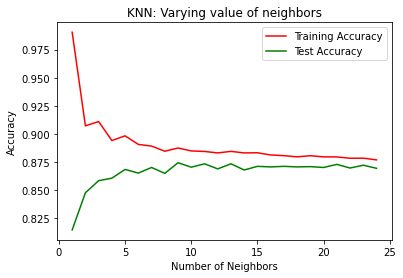

In [61]:
# Training accuracy
plt.plot(neighbors,train_accuracy.values(),label='Training Accuracy',color='red')

# Testing accuracy
plt.plot(neighbors,test_accuracy.values(),label='Test Accuracy',color='green')

plt.legend()
plt.title('KNN: Varying value of neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [62]:
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train,y_train)

# retrieve predictions of y_test using our model
knn_y_pred = knn.predict(X_test)
knn_y_pred

array([0, 1, 0, ..., 1, 0, 1])

**Summarizing Model**

Combining the above two results, we can conclude the best result can be achieve when k equals to 9, so n_neighbor=9 will be used in our final model.

### **Logistic Regression**



Apart from KNN, we can also use logistic regression to address classification.

We will quickly set up logistic regression, fit the model, and make a prediction using the features and variable assignments we have established above

In [63]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
log_reg_y_pred = log_reg.predict(X_test)

## **Model Performance Analysis**

Now that our two models are built, our next step is to evaluate the goodness of the two models. In other words, we need to compare the predicted value and the actual value of y. Here, we are going to use the imported confusion matrix, classification report, and ROC-AUC to assess the models.

**Confusion matrices**

We generate confusion matrix for knn model and logistic regression model to showcase the number of True Negative, False Positive, False Negative, and True Positive.

In [64]:
knn_cm = confusion_matrix(y_test,knn_y_pred)
print (knn_cm)

[[2914  175]
 [ 333  578]]


In [65]:
log_reg_cm = confusion_matrix(y_test,log_reg_y_pred)
print(log_reg_cm)

[[2921  168]
 [ 398  513]]


**Classification reports**

We generate classification reports to overview additional statistics for the models

In [67]:
knn_cr = classification_report(y_test,knn_y_pred)
print("Classification report for knn model")
print (knn_cr)
print()

# generate classification report for logistic regression model
print("Classification report for logistic regression model")
log_reg_cr = classification_report(y_test,log_reg_y_pred)
print (log_reg_cr)

Classification report for knn model
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3089
           1       0.77      0.63      0.69       911

    accuracy                           0.87      4000
   macro avg       0.83      0.79      0.81      4000
weighted avg       0.87      0.87      0.87      4000


Classification report for logistic regression model
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      3089
           1       0.75      0.56      0.64       911

    accuracy                           0.86      4000
   macro avg       0.82      0.75      0.78      4000
weighted avg       0.85      0.86      0.85      4000



Classification report introduces several elements such as precision, recall, f1-score and accuracy.

**Precision**: TP / (TP+FP). It is the ratio of correctly predicting positive observations to the total predicted positive observations. In our case, it answers the question "Of all cars that are believed to be above 10,000, how many cars are actually above 10,000".

**Recall**: TP/ (TP+FN). It is the ratio of correctly predicting positive observations to all actual positive cases. Here, it helps us understand of all the cars that are above 10,000, how many of them do we label as above 10,000.

**Accuracy**: The number of correct predictions over the total number of predictions.

**F1-score**: It is the harmonic mean of the precision and recall for each class. F1 is usually more useful than accuracy, especially when we have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.

In our case, we think the cost of false positive and false negative is the same, so we are going to use accuracy as our measurement. Based on the above results, KNN scores higher (0.87) than logistic regression (0.86).

**Creating ROC curves to view classification model performance at all classification thresholds.**

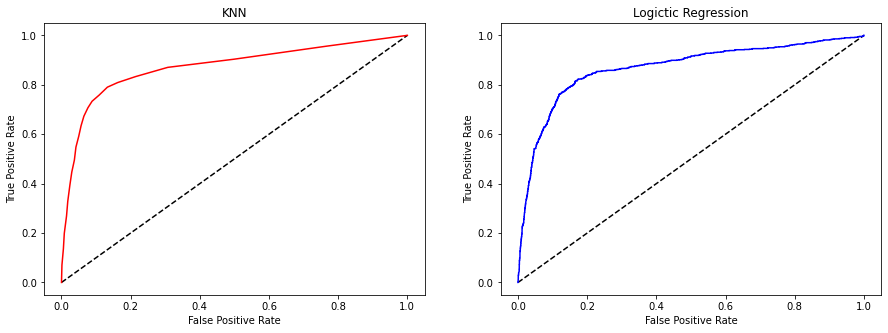

In [68]:
fig=plt.figure(figsize=(15,5))
plt.title("ROC curve comparisons")

# KNN
# Create ROC curve for KNN model
plt.subplot(1,2,1)
knn_pos_probs = knn.predict_proba(X_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,knn_pos_probs)

# plot fpr, tpr in the graph
plt.plot([0,1],[0,1],"--k")
plt.plot(fpr,tpr,color='red')
plt.title('KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


# Create ROC curve for logistic regression model
plt.subplot(1,2,2)
log_reg_pos_probs = log_reg.predict_proba(X_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,log_reg_pos_probs)

# plot fpr, tpr in the graph
plt.plot([0,1],[0,1],"--k")
plt.plot(fpr,tpr,color='blue')
plt.title('Logictic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


plt.show()

**Getting AUC values for KNN and logistic regression**

In [70]:
knn_auc = roc_auc_score(y_test,knn_y_pred)
log_reg_auc = roc_auc_score(y_test,log_reg_y_pred)
print ('KNN AUC score:',knn_auc,'\n','Logistic regression AUC score:',log_reg_auc)

KNN AUC score: 0.7889074898039466 
 Logistic regression AUC score: 0.7543654602447195


## Conclusions

We are at the point where we conclude which model is optimal for our predictions. With an AUC score of 0.7889 for the KNN model, compared to the logistic regression AUC score of 0.7543, the KNN is our choice. This superior performance metric tell us that KNN will be a better model to predict car prices in our case.